In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adult-census-income/adult.csv


# Initial import and useful functions

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

In [3]:
df_data = pd.read_csv('/kaggle/input/adult-census-income/adult.csv')

In [4]:
# Useful functions


####################
def split_numerical_categorical_cols(df):
    """
    Simple function to get numerical and categorical cols of a dataframe splitted.

    Parameters:
    - df: The dataframe to analyze.

    Return:
    - Numerical_cols: Only the numerical cols of the initial dataframe.
    - Categorical_cols: Only the categorical cols of the initial dataframe.
    """
    numerical_cols = [colname for colname in df.columns if df[colname].dtype in ['int64', 'float64']]
    categorical_cols = [colname for colname in df.columns if df[colname].dtype in ['object']]
    return numerical_cols, categorical_cols


####################
def get_columns_info(df):
    """
    Function to show initial information about the columns in the dataframe.
    You will get the shape, total nulls and total nulls per column,
    and a summary of numerical and categorical vars separately.

    Parameters:
    - df: The dataframe to analyze.
    """
    numerical_cols, categorical_cols = split_numerical_categorical_cols(df)
    
    numerical_df = df[numerical_cols]
    numerical_summary = pd.DataFrame({
        'DataType': numerical_df.dtypes,
        'Min': numerical_df.min(),
        'Max': numerical_df.max(),
    })

    print("\nNumerical Summary:", numerical_summary)
    print("Categorical Summary:\n")

    for categorical_col in categorical_cols:
        print(f"Column ({categorical_col}) - Type ({df[categorical_col].dtype}) -> Options ({df[categorical_col].unique()})")


####################
def plot_distribution(target, msg='', more_size=False):
    """
    Function to plot the distribution of a feature

    Parameters:
    - target: The feature to analyze.
    - msg: A message to print into the plot.
    - more_size (optional): To create a bigger plot.
    """
    unique, counts_uniques = np.unique(target, return_counts=True)
    print(counts_uniques)

    if more_size: plt.figure(figsize=(12,8))
    else: plt.figure(figsize=(6,4))
    
    plt.bar(unique, counts_uniques)
    plt.title("Distribution")

    plt.xticks(rotation=45, ha='right')
    plt.xlabel(f"{str(msg)}")
    plt.ylabel("Quantity")

    plt.show()

    return counts_uniques


####################
def show_features_importance(model, X, more_size=False):
    """
    Function to get and show the features importance in a model.
    You will get the shape, total nulls and total nulls per column,
    and a summary of numerical and categorical vars separately.

    Parameters:
    - model: The model to check the features importance.
    - X: Features to check.
    - more_size (optional): To create a bigger plot.

    Return:
    - feature_importances_df (pd.Dataframe): DataFrame with the features in descendent order of importance
    
    """
    feature_importances_df = pd.DataFrame(
        {"feature": list(X.columns), "importance": model.feature_importances_}
    ).sort_values("importance", ascending=False)
    
    print('Feature importances:\n', feature_importances_df)
    
    if more_size: fig = plt.figure(figsize=(12,8))
    else: fig = plt.figure(figsize=(8,6))
    sns.barplot(x=feature_importances_df.feature, y=feature_importances_df.importance)
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title("Showing features importance")
    plt.xticks(rotation=45, horizontalalignment="right", fontweight='light', fontsize="x-large")

    return feature_importances_df


####################
def get_confmatrix_and_report(y_train, y_test, y_train_pred, y_test_pred):
    """
    Function to plot the confusion matrix and create a report with some metrics.

    Parameters:
    - y_train: Train target variable.
    - y_test: Test target variable.
    - y_train_pred: Predictions of the model in train data.
    - y_test_pred: Prediction of the model in test data.
    """
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print('Accuracy train:', train_accuracy)
    print('Accuracy test:', test_accuracy)
    print('\nClassificacion report:\n', classification_report(y_test, y_test_pred))
    
    fig = plt.figure(figsize=(6,6))
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot(cmap='gray', ax=plt.gca())
    plt.gca().grid(False)
    plt.show()

In [5]:
df_data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [6]:
print('Shape of initial data ->', df_data.shape)

Shape of initial data -> (32561, 15)


In [7]:
df_data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [8]:
get_columns_info(df_data)
numerical_cols, categorical_cols = split_numerical_categorical_cols(df_data)


Numerical Summary:                DataType    Min      Max
age               int64     17       90
fnlwgt            int64  12285  1484705
education.num     int64      1       16
capital.gain      int64      0    99999
capital.loss      int64      0     4356
hours.per.week    int64      1       99
Categorical Summary:

Column (workclass) - Type (object) -> Options (['?' 'Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay' 'Never-worked'])
Column (education) - Type (object) -> Options (['HS-grad' 'Some-college' '7th-8th' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-acdm' 'Assoc-voc' '1st-4th' '5th-6th'
 '12th' '9th' 'Preschool'])
Column (marital.status) - Type (object) -> Options (['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse'])
Column (occupation) - Type (object) -> Options (['?' 'Exec-managerial' 'Machine-op-inspct' 'Prof-specialty'
 'Other-service

In [9]:
question_counts_per_column = df_data.apply(lambda col: col.astype(str).str.contains(r'\?', na=False).sum())
print("Number of '?' in each column:\n")
print(question_counts_per_column)
rows_with_question = df_data.astype(str).apply(lambda col: col.str.contains(r'\?', na=False)).any(axis=1).sum()
print("\nNumber of rows with at least one value containing '?':", rows_with_question)

Number of '?' in each column:

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

Number of rows with at least one value containing '?': 2399


In [10]:
print('Number of duplicated rows:', df_data.duplicated().sum())

Number of duplicated rows: 24


## Initial context, observations and information

Initial columns and a brief description:
- age (int, range -> from 17 to 90)
- workclass (categorical -> Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked)
- fnlwgt (int, range -> from 12285 to 1484705): Seems to mean how many people represents each entry
- education (categorical -> Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool)
- education-num (int, range -> from 1 to 16): Same information as education but encoded in ascending order
- marital.status (categorical -> Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse)
- occupation (categorical -> Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces)
- relationship (categorical -> Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried)
- race (categorical -> White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black)
- sex (categorical -> Female, Male)
- capital.gain (int, range -> from 0 to 99999)
- capital.loss (int, range -> from 0 to 4356)
- hours.per.week (int, range -> from 1 to 99)
- native.country (categorical -> United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands)
- income (categorical -> >50K, <=50K): Represents if each person has earn more than 50k per year

Initial observations:
- There are some null values in the data, but these values are represented with '?' instead of being standard nulls recognizable by numpy.
    - There are 2399 entries in this dataset that contain null values.
    - All null values are located in the rows *workclass, occupation and native.country*.
    - These values will be handled later.
- There are 24 duplicated rows that will be deleted.

# Exploratory Data Analysis

In [11]:
df_eda = df_data.copy(deep=True)

## Data cleaning and simplification

In [12]:
df_eda = df_eda.drop_duplicates()
df_eda = df_eda.replace('?', np.nan)

In [13]:
question_counts_per_column = df_eda.apply(lambda col: col.astype(str).str.contains(r'\?', na=False).sum())
print("Number of '?' in each column:\n")
print(question_counts_per_column)
rows_with_question = df_eda.astype(str).apply(lambda col: col.str.contains(r'\?', na=False)).any(axis=1).sum()
print("\nNumber of rows with at least one value containing '?':", rows_with_question)

Number of '?' in each column:

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

Number of rows with at least one value containing '?': 0


In [14]:
df_eda.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     582
income               0
dtype: int64

In [15]:
df_eda['workclass'] = df_eda['workclass'].fillna('Unknown')
df_eda['occupation'] = df_eda['occupation'].fillna('Unknown')
df_eda['native.country'] = df_eda['native.country'].fillna('Unknown')

df_data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [16]:
df_eda.head(10)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,Unknown,77053,HS-grad,9,Widowed,Unknown,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Unknown,186061,Some-college,10,Widowed,Unknown,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
7,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,>50K
8,68,Federal-gov,422013,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,0,3683,40,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,Unknown,>50K


[24698  7839]


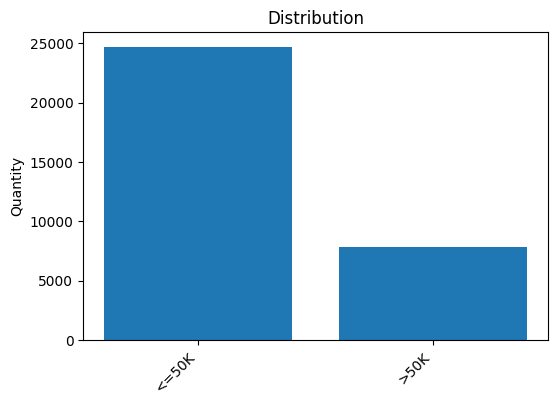

array([24698,  7839])

In [17]:
plot_distribution(df_eda['income'])

In [18]:
df_eda['income'] = df_eda['income'].map({"<=50K":0,">50K":1})

In [19]:
df_eda.head(10)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,Unknown,77053,HS-grad,9,Widowed,Unknown,Not-in-family,White,Female,0,4356,40,United-States,0
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
2,66,Unknown,186061,Some-college,10,Widowed,Unknown,Unmarried,Black,Female,0,4356,40,United-States,0
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,0
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,0
7,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,1
8,68,Federal-gov,422013,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,0,3683,40,United-States,0
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,Unknown,1


<Axes: xlabel='income', ylabel='count'>

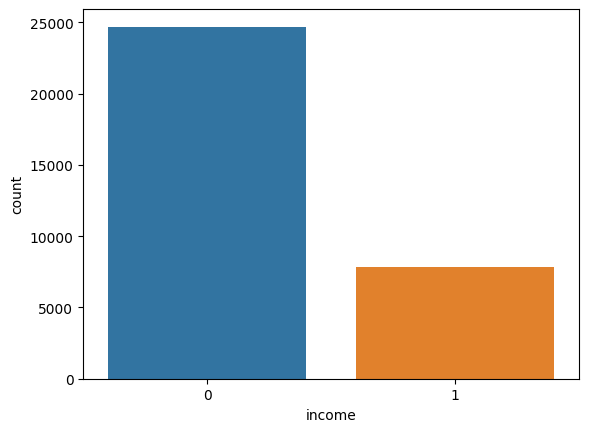

In [20]:
sns.countplot(x='income',data=df_eda)

At this point, the data no longer has duplicate values ​​and null values ​​are handled. Null values ​​have been replaced with *Unknown* and will be decided upon later based on the rest of the data.

The target variable *income* has been coded to indicate with 0 or 1 whether or not your income is over 50k. Furthermore, this variable is highly unbalanced, having approximately a 3 to 1 ratio.




## Main information and distribution of columns

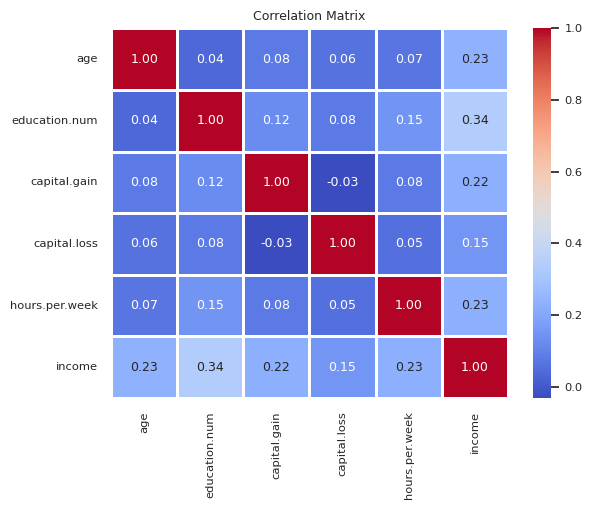

In [21]:
df_aux = df_eda.copy()
df_aux.drop('fnlwgt', axis=1, inplace=True)
aux_numerical_cols, aux_categorical_cols = split_numerical_categorical_cols(df_aux)

cm = np.corrcoef(df_aux[aux_numerical_cols].values.T)
sns.set(font_scale=0.75)
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1, yticklabels=aux_numerical_cols, xticklabels=aux_numerical_cols)
plt.title('Correlation Matrix')
plt.show()

Related to the correlation matrix, it is clear that the target variable do not have high correlation with any other column. Additionaly, there is not any high correlation between any couple of columns.

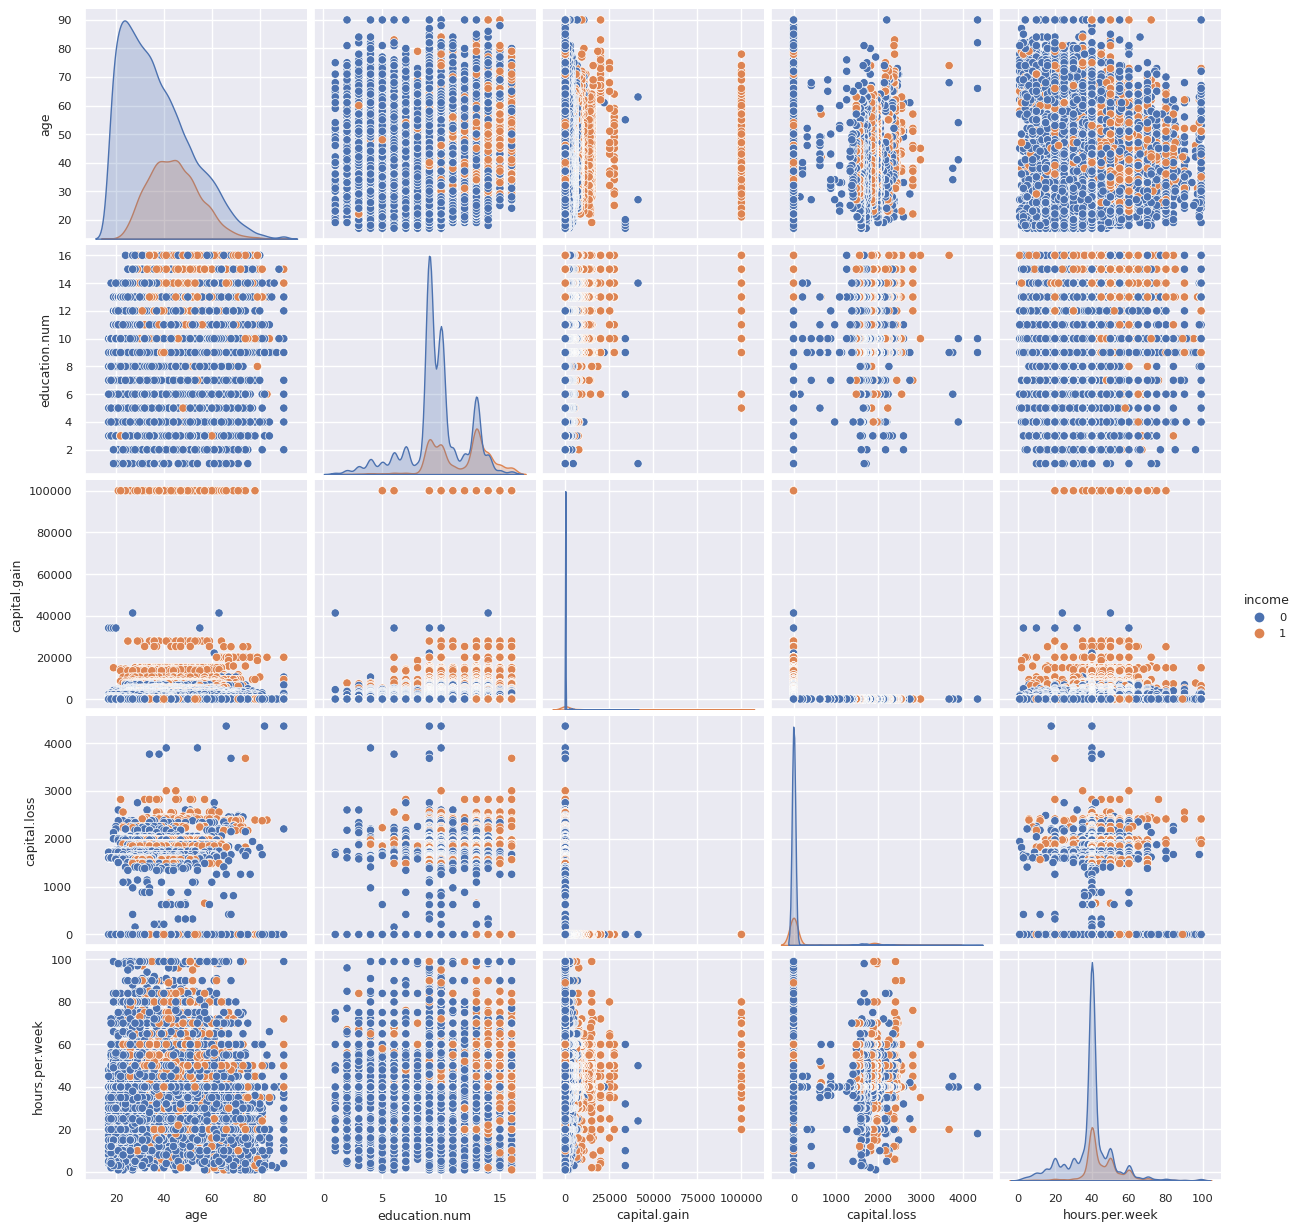

In [22]:
sns.pairplot(df_aux, hue='income', height=2.5)
plt.show()

<Axes: xlabel='education.num', ylabel='count'>

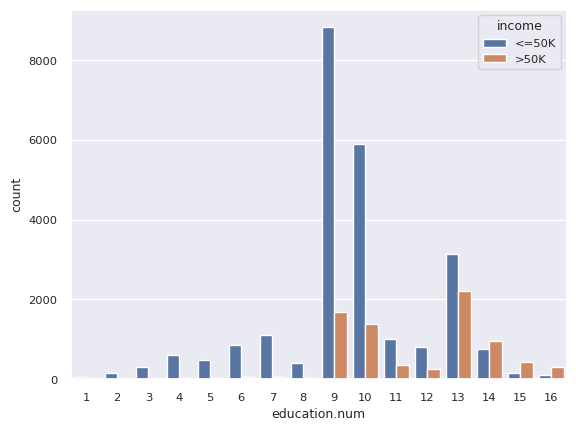

In [23]:
sns.countplot(data=df_data, x='education.num', hue='income')

<Axes: xlabel='hours.per.week', ylabel='Count'>

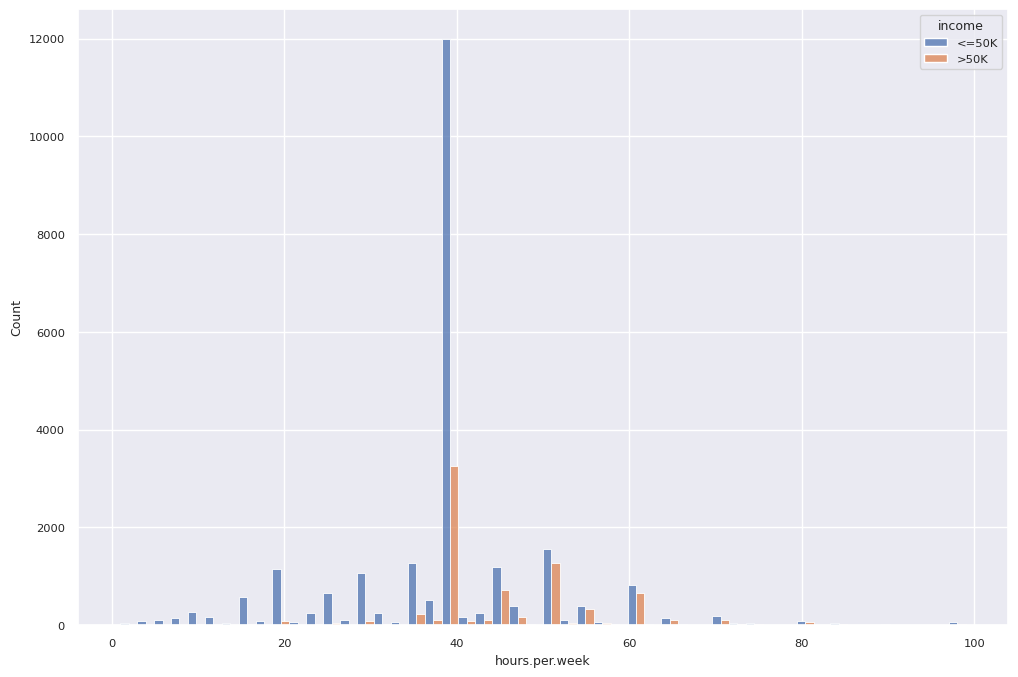

In [24]:
plt.figure(figsize=(12,8))
sns.histplot(data=df_data, x='hours.per.week', bins=50, hue='income', multiple='dodge')

[  960  2093     7 22673  1116  2540  1298  1836    14]


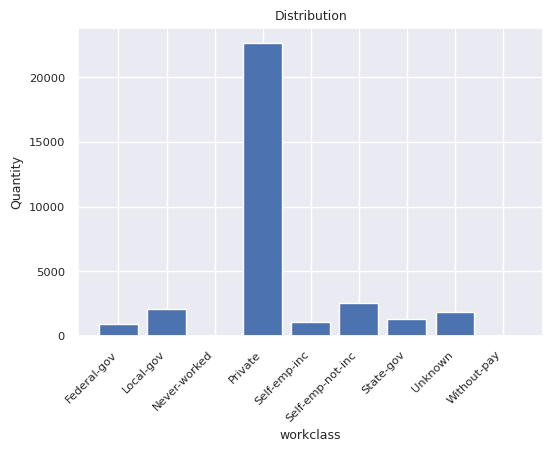

[  933  1175   433   166   332   645   514  1067  1382  5353   413 10494
  1722    50   576  7282]


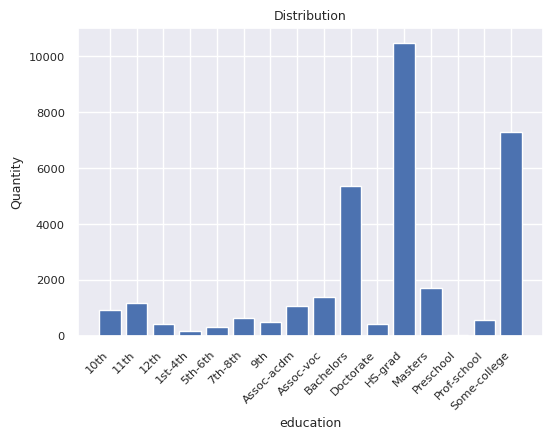

[ 4441    23 14970   418 10667  1025   993]


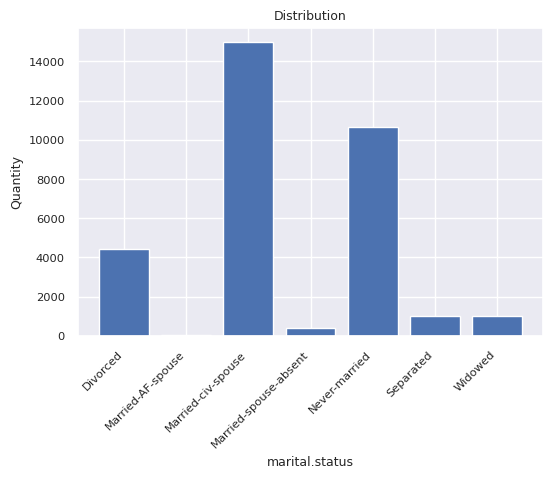

[3768    9 4094 4065  992 1369 2000 3291  147 4136  649 3650  927 1597
 1843]


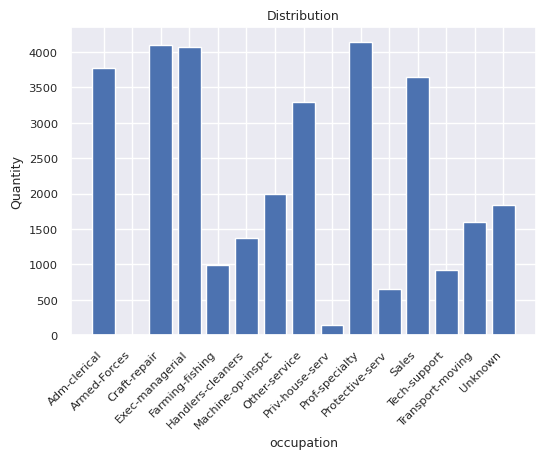

[13187  8292   981  5064  3445  1568]


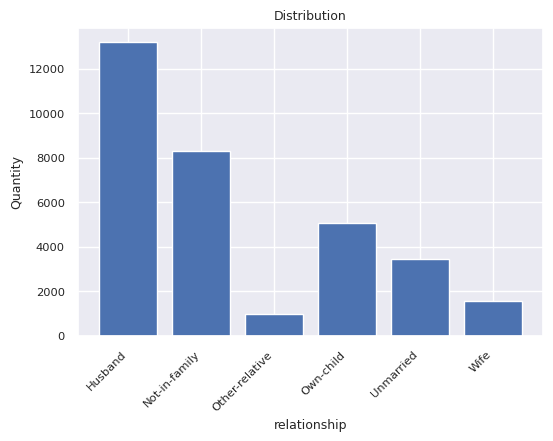

[  311  1038  3122   271 27795]


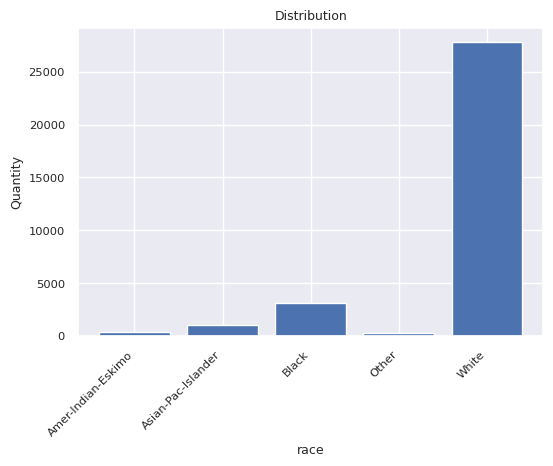

[10762 21775]


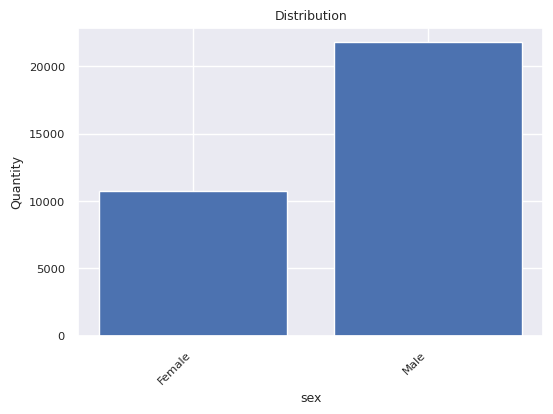

[   19   121    75    59    95    70    28   106    90    29   137    29
    62    44     1    13    20    13   100    43    24    73    81    62
    18   639    34    14    31   198    60    37   114    12    80    51
    18    19 29153   582    67    16]


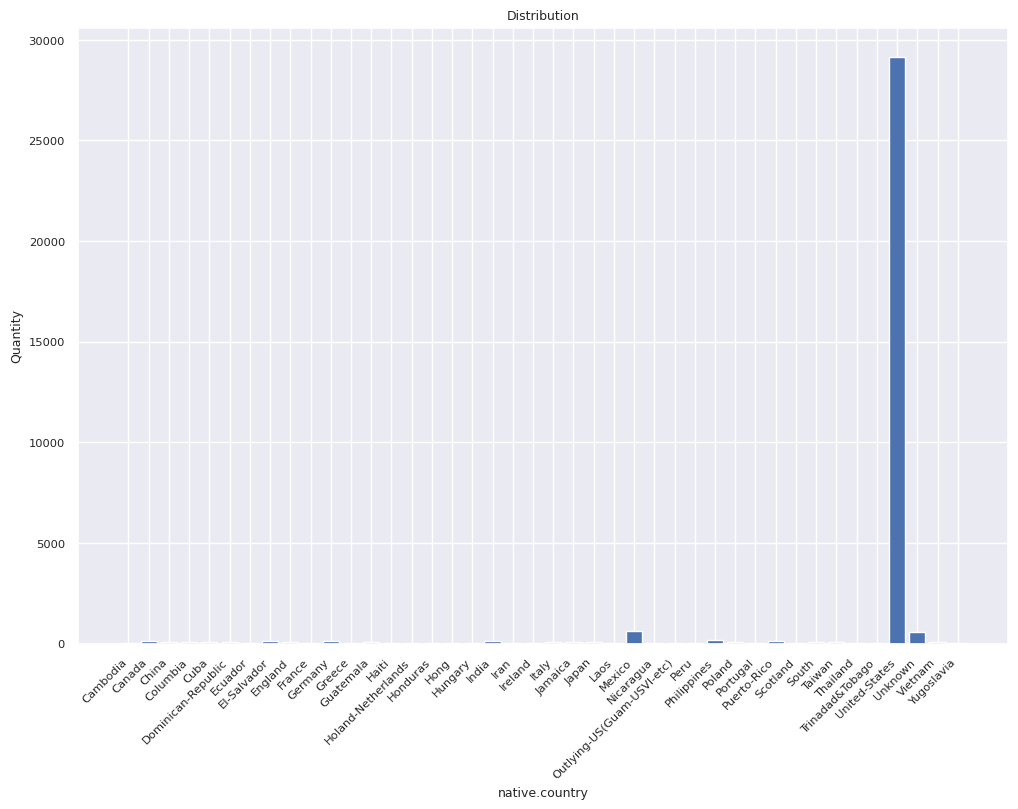

In [25]:
for cat in categorical_cols:
    if cat == 'native.country': plot_distribution(df_eda[cat], msg=cat, more_size=True)
    elif cat != 'income': plot_distribution(df_eda[cat], msg=cat)

<Axes: ylabel='age'>

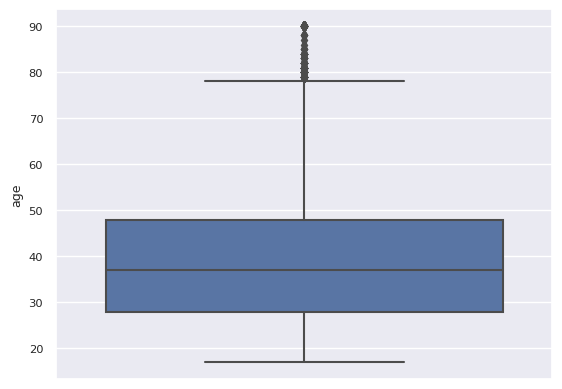

In [26]:
sns.boxplot(data = df_eda, y = 'age')

<Axes: ylabel='education.num'>

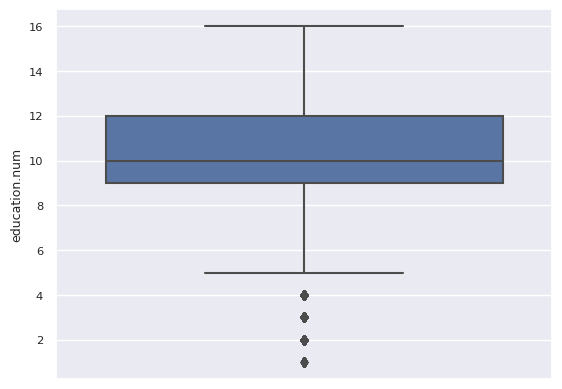

In [27]:
sns.boxplot(data = df_eda, y = 'education.num')

Main observations from this part:

- Related to the correlation matrix, it is clear that the target variable do not have high correlation with any other column. Additionaly, there is not any high correlation between any couple of columns.
- All columns are unbalanced.
- Education level has a huge impact in the target variable, because there isn't almost any entry with more income than 50k in lower values of education.
- Hours per weeks seems to be also relevant for the target variable, but not as education level.
- Education and age have some outliers.
- Workclass and race are specially unbalanced, and native country is extremely unbalanced (almost 90% of data belongs to the same category)

## Featuring engineering

In [28]:
df_fe = df_eda.copy(deep=True)

In [29]:
## Grouped only between 'Private', 'Government', 'Self-employed' and 'No-incomes' for simplicity
df_fe['workclass'] = df_fe['workclass'].map({
    'Private': 'Private',
    'State-gov': 'Government',
    'Federal-gov': 'Government',
    'Local-gov': 'Government',
    'Self-emp-not-inc': 'Self-employed',
    'Self-emp-inc': 'Self-employed',
    'Without-pay': 'No-incomes',
    'Never-worked': 'No-incomes',
    'Unknown': 'No-incomes'
})

## Split into different common adult ranges
df_fe['age_group_cats'] = pd.cut(df_fe['age'], bins=[0, 30, 50, 90], labels=['Young', 'Adult', 'Senior'])
df_fe['age_group_ordenc'] = pd.cut(df_fe['age'], bins=[0, 30, 50, 90], labels=[0, 1, 2]).astype(int)

## Obtaining the final capital balance instead of having only both gain and loss capital
df_fe['capital_balance'] = df_fe['capital.gain'] - df_fe['capital.loss']

## Split into different time ranges 
df_fe['week_hours_cats'] = pd.cut(df_fe['hours.per.week'], bins=[0, 35, 40, 60, 100], 
                                        labels=['Mid-time', 'Full-time', 'Severe-time', 'Extreme-time'])
df_fe['week_hours_ordenc'] = pd.cut(df_fe['hours.per.week'], bins=[0, 35, 40, 60, 100], labels=[0, 1, 2, 3]).astype(int)

## Grouped into different classes for compactness, specially School
df_fe['education_cats'] = pd.cut(df_fe['education.num'], bins=[0,8,9,10,12,13,16], 
                                  labels=['School', 'HS-grad', 'Some-college', 'Associated','Bachelors','Post-Bachelor'])
df_fe['education_ordenc'] = pd.cut(df_fe['education.num'], bins=[0,8,9,10,12,13,16], labels=[0, 1, 2, 3, 4, 5]).astype(int)

## Groupped into less detailed status
df_fe['marital.status'] = df_fe['marital.status'].map({
    'Widowed': 'Past-married',
    'Divorced': 'Past-married',
    'Separated': 'Past-married',
    'Never-married': 'Never-married',
    'Married-civ-spouse': 'Now-married',
    'Married-AF-spouse': 'Now-married',
    'Married-spouse-absent': 'Now-married-absent'
})

## Groupped into less detailed race type
df_fe['race'] = df_fe['race'].map({
    'Other': 'Other',
    'Amer-Indian-Eskimo': 'Black',
    'Black': 'Black',
    'White': 'White',
    'Asian-Pac-Islander': 'White',
})

## Divided native country only in United-States or not United-States due to the unbalanced data
df_fe['native.country'] = df_fe['native.country'].apply(lambda x: 'United-States' if str(x) == 'United-States' else 'Other')

# Occupation? Don't seems to have a clear way of join the data into less number of classes
# Relationship? Apart from doesn't have a clear way for join more the data, data is strongly correlated with marital.status 

In [30]:
df_fe.head(10)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,...,hours.per.week,native.country,income,age_group_cats,age_group_ordenc,capital_balance,week_hours_cats,week_hours_ordenc,education_cats,education_ordenc
0,90,No-incomes,77053,HS-grad,9,Past-married,Unknown,Not-in-family,White,Female,...,40,United-States,0,Senior,2,-4356,Full-time,1,HS-grad,1
1,82,Private,132870,HS-grad,9,Past-married,Exec-managerial,Not-in-family,White,Female,...,18,United-States,0,Senior,2,-4356,Mid-time,0,HS-grad,1
2,66,No-incomes,186061,Some-college,10,Past-married,Unknown,Unmarried,Black,Female,...,40,United-States,0,Senior,2,-4356,Full-time,1,Some-college,2
3,54,Private,140359,7th-8th,4,Past-married,Machine-op-inspct,Unmarried,White,Female,...,40,United-States,0,Senior,2,-3900,Full-time,1,School,0
4,41,Private,264663,Some-college,10,Past-married,Prof-specialty,Own-child,White,Female,...,40,United-States,0,Adult,1,-3900,Full-time,1,Some-college,2
5,34,Private,216864,HS-grad,9,Past-married,Other-service,Unmarried,White,Female,...,45,United-States,0,Adult,1,-3770,Severe-time,2,HS-grad,1
6,38,Private,150601,10th,6,Past-married,Adm-clerical,Unmarried,White,Male,...,40,United-States,0,Adult,1,-3770,Full-time,1,School,0
7,74,Government,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,...,20,United-States,1,Senior,2,-3683,Mid-time,0,Post-Bachelor,5
8,68,Government,422013,HS-grad,9,Past-married,Prof-specialty,Not-in-family,White,Female,...,40,United-States,0,Senior,2,-3683,Full-time,1,HS-grad,1
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,...,60,Other,1,Adult,1,-3004,Severe-time,2,Some-college,2


In [31]:
df_fe.dtypes

age                     int64
workclass              object
fnlwgt                  int64
education              object
education.num           int64
marital.status         object
occupation             object
relationship           object
race                   object
sex                    object
capital.gain            int64
capital.loss            int64
hours.per.week          int64
native.country         object
income                  int64
age_group_cats       category
age_group_ordenc        int64
capital_balance         int64
week_hours_cats      category
week_hours_ordenc       int64
education_cats       category
education_ordenc        int64
dtype: object

## Preprocessing data

In [32]:
#df_preproc = df_fe.copy(deep=True)

ordinal_cols = ['age_group_ordenc','week_hours_ordenc', 'education_ordenc'] 
onehot_cols = ['workclass', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']

df_ordenc_prev = df_fe[ordinal_cols]
df_onehot_prev = pd.get_dummies(df_fe[onehot_cols], drop_first=True).astype(int)

df_preproc = pd.concat([df_ordenc_prev, df_onehot_prev], axis=1)
df_preproc['income'] = df_fe['income']
df_preproc.head(10)

,age_group_ordenc,week_hours_ordenc,education_ordenc,workclass_No-incomes,workclass_Private,workclass_Self-employed,marital.status_Now-married,marital.status_Now-married-absent,marital.status_Past-married,occupation_Armed-Forces,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Other,race_White,sex_Male,native.country_United-States,income
0,2,1,1,1,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
1,2,0,1,0,1,0,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
2,2,1,2,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
3,2,1,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0
4,1,1,2,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,1,0
5,1,2,1,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0
6,1,1,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,1,1,0
7,2,0,5,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,1
8,2,1,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
9,1,2,2,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,1


In [33]:
df_preproc.dtypes

age_group_ordenc                     int64
week_hours_ordenc                    int64
education_ordenc                     int64
workclass_No-incomes                 int64
workclass_Private                    int64
workclass_Self-employed              int64
marital.status_Now-married           int64
marital.status_Now-married-absent    int64
marital.status_Past-married          int64
occupation_Armed-Forces              int64
occupation_Craft-repair              int64
occupation_Exec-managerial           int64
occupation_Farming-fishing           int64
occupation_Handlers-cleaners         int64
occupation_Machine-op-inspct         int64
occupation_Other-service             int64
occupation_Priv-house-serv           int64
occupation_Prof-specialty            int64
occupation_Protective-serv           int64
occupation_Sales                     int64
occupation_Tech-support              int64
occupation_Transport-moving          int64
occupation_Unknown                   int64
relationshi

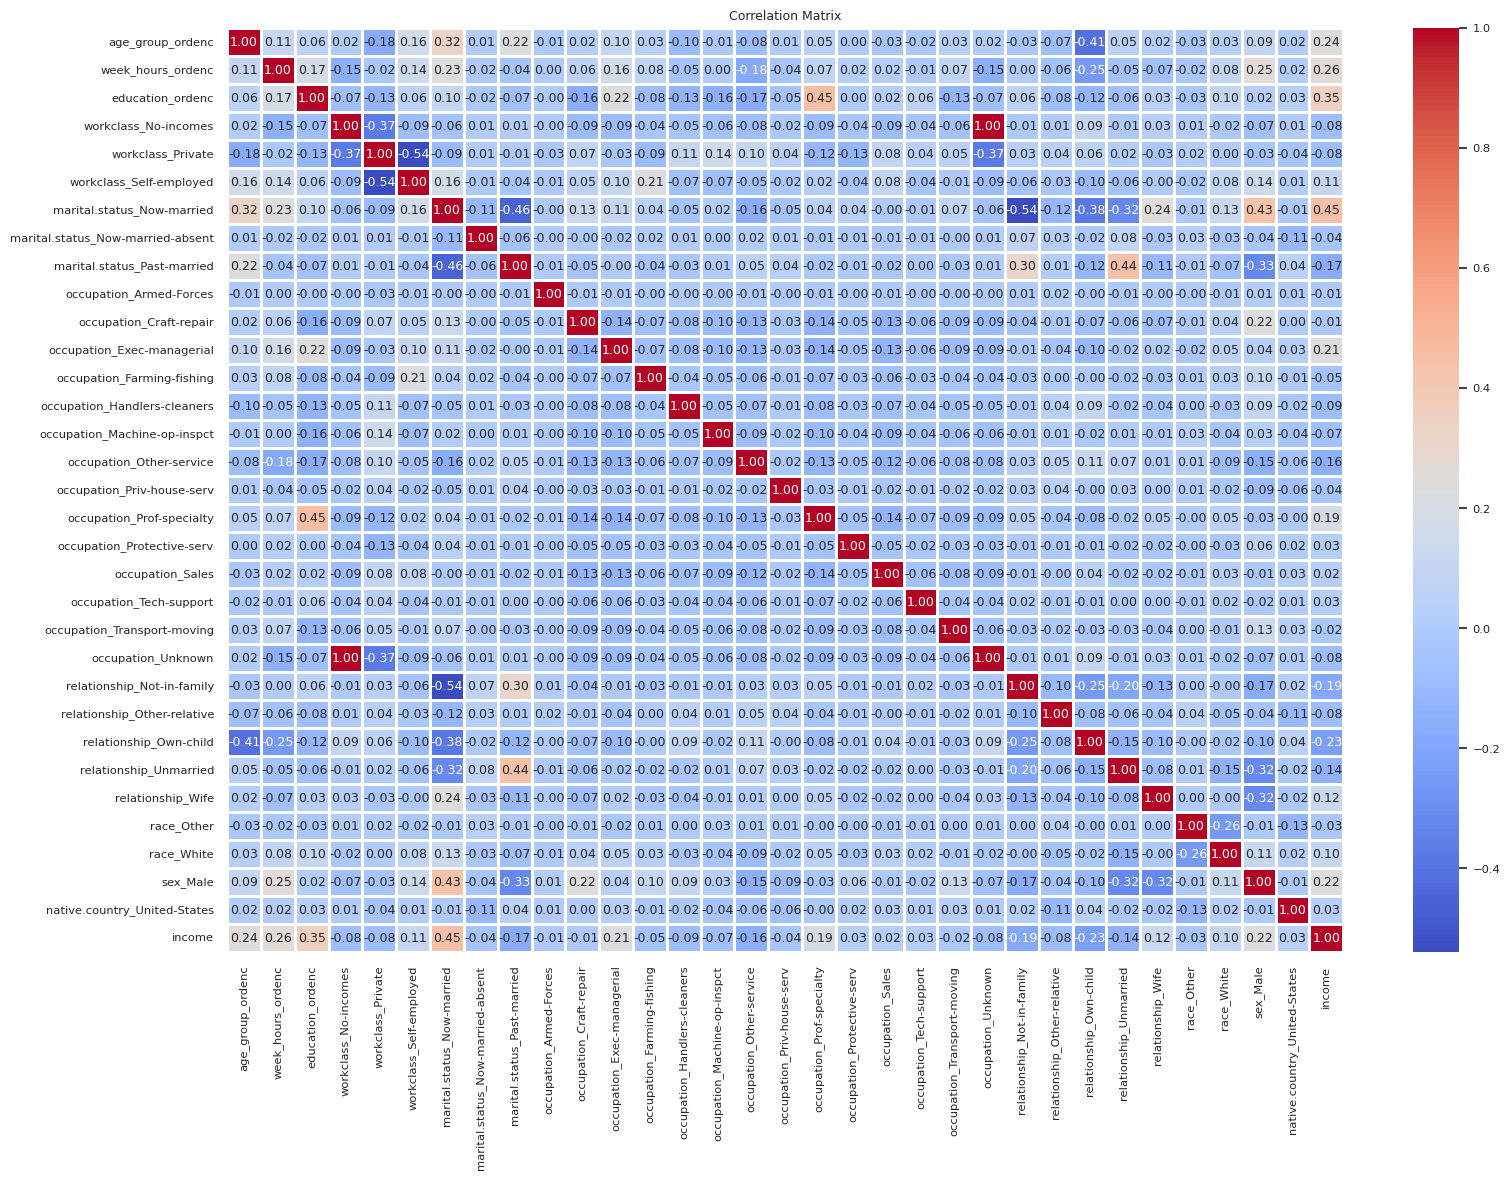

In [34]:
aux_numerical_cols, aux_categorical_cols = split_numerical_categorical_cols(df_preproc)

cm = np.corrcoef(df_preproc[aux_numerical_cols].values.T)
plt.figure(figsize=(18,12))
sns.set(font_scale=0.75)
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1, yticklabels=aux_numerical_cols, xticklabels=aux_numerical_cols)
plt.title('Correlation Matrix')
plt.show()

income                               1.000000
marital.status_Now-married           0.445202
education_ordenc                     0.349707
week_hours_ordenc                    0.257194
age_group_ordenc                     0.242567
sex_Male                             0.215969
occupation_Exec-managerial           0.214889
occupation_Prof-specialty            0.185879
relationship_Wife                    0.123230
workclass_Self-employed              0.105858
race_White                           0.100554
native.country_United-States         0.034206
occupation_Protective-serv           0.028086
occupation_Tech-support              0.025773
occupation_Sales                     0.023598
occupation_Armed-Forces             -0.005049
occupation_Craft-repair             -0.012428
occupation_Transport-moving         -0.021543
race_Other                          -0.031861
occupation_Priv-house-serv          -0.036882
marital.status_Now-married-absent   -0.042571
occupation_Farming-fishing        

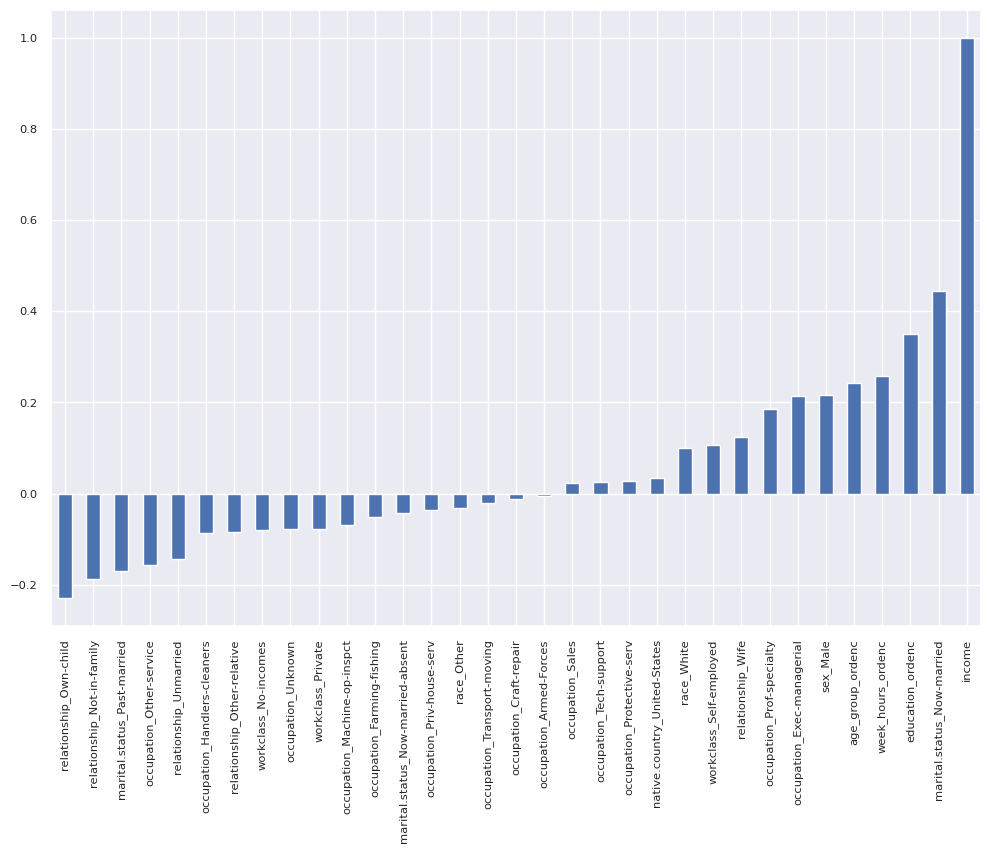

In [35]:
fig = plt.figure(figsize=(12,8))
df_preproc.corr()['income'].sort_values(ascending=True).plot(kind='bar')
print(df_preproc.corr()['income'].sort_values(ascending=False))
plt.show()

In [36]:
# Deleting the columns with too high correlation between them
df_preproc.drop(['workclass_No-incomes', 'relationship_Not-in-family'], axis=1, inplace=True)

# Random Forest

## RF model creation and evaluation

In [37]:
X = df_preproc.drop(columns=['income'])
y = df_preproc['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
random_forest = RandomForestClassifier(n_estimators=150, random_state=0)
random_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=0)

Accuracy train: 0.8839077936333699
Accuracy test: 0.8202212661339889

Classificacion report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88      7456
           1       0.63      0.57      0.60      2306

    accuracy                           0.82      9762
   macro avg       0.75      0.73      0.74      9762
weighted avg       0.81      0.82      0.82      9762



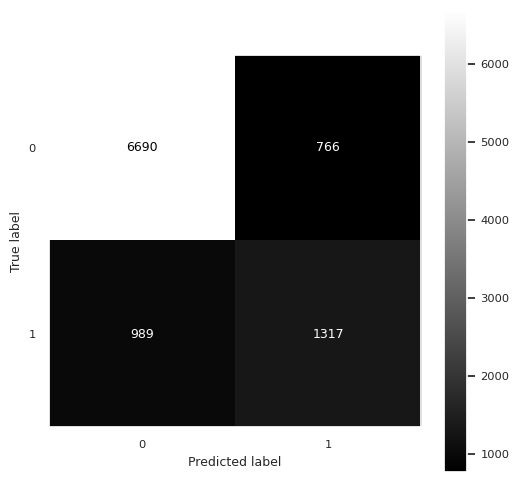

In [39]:
y_train_pred = random_forest.predict(X_train)
y_test_pred = random_forest.predict(X_test)

get_confmatrix_and_report(y_train, y_test, y_train_pred, y_test_pred)

Feature importances:
                               feature  importance
2                    education_ordenc    0.212961
5          marital.status_Now-married    0.183153
0                    age_group_ordenc    0.108901
1                   week_hours_ordenc    0.103219
10         occupation_Exec-managerial    0.040232
28                           sex_Male    0.036052
16          occupation_Prof-specialty    0.031500
3                   workclass_Private    0.028845
7         marital.status_Past-married    0.026485
29       native.country_United-States    0.024970
27                         race_White    0.023025
23             relationship_Own-child    0.021687
4             workclass_Self-employed    0.020141
25                  relationship_Wife    0.017054
14           occupation_Other-service    0.015917
24             relationship_Unmarried    0.014181
18                   occupation_Sales    0.014125
9             occupation_Craft-repair    0.011607
11         occupation_Farmin

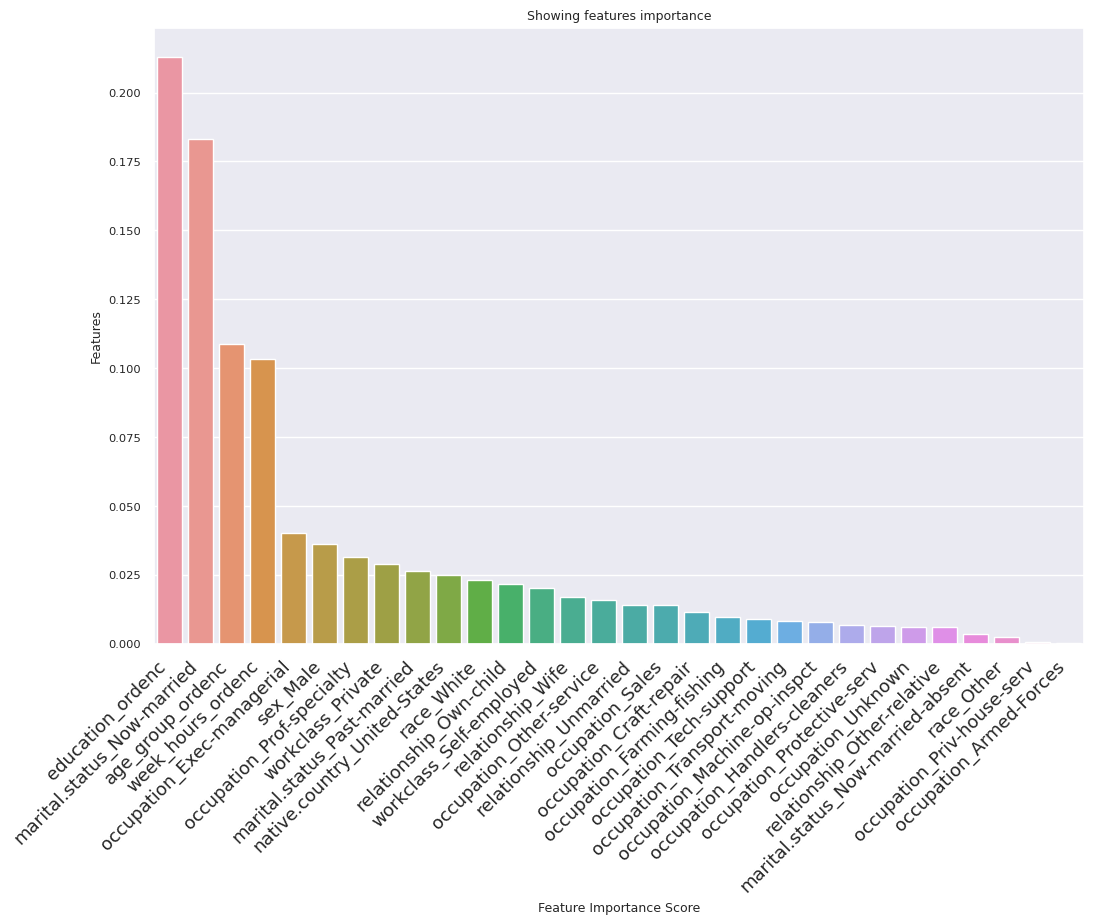

In [40]:
features_importance_df = show_features_importance(random_forest, X, more_size=True)

## Second RF model and evaluation

In [41]:
filtered_features_df = features_importance_df[(features_importance_df["importance"] > 0.025)]
filtered_features_list = list(filtered_features_df['feature'])
filtered_features_list.append('income')
print(filtered_features_list)

df_rf_cut = df_preproc[filtered_features_list]
df_rf_cut.head()

['education_ordenc', 'marital.status_Now-married', 'age_group_ordenc', 'week_hours_ordenc', 'occupation_Exec-managerial', 'sex_Male', 'occupation_Prof-specialty', 'workclass_Private', 'marital.status_Past-married', 'income']


,education_ordenc,marital.status_Now-married,age_group_ordenc,week_hours_ordenc,occupation_Exec-managerial,sex_Male,occupation_Prof-specialty,workclass_Private,marital.status_Past-married,income
0,1,0,2,1,0,0,0,0,1,0
1,1,0,2,0,1,0,0,1,1,0
2,2,0,2,1,0,0,0,0,1,0
3,0,0,2,1,0,0,0,1,1,0
4,2,0,1,1,0,0,1,1,1,0


In [42]:
X = df_rf_cut.drop(columns=['income'])
y = df_rf_cut['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
random_forest = RandomForestClassifier(n_estimators=150, random_state=0)
random_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=0)

Accuracy train: 0.8440834248079034
Accuracy test: 0.8255480434337226

Classificacion report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      7456
           1       0.67      0.52      0.58      2306

    accuracy                           0.83      9762
   macro avg       0.76      0.72      0.74      9762
weighted avg       0.82      0.83      0.82      9762



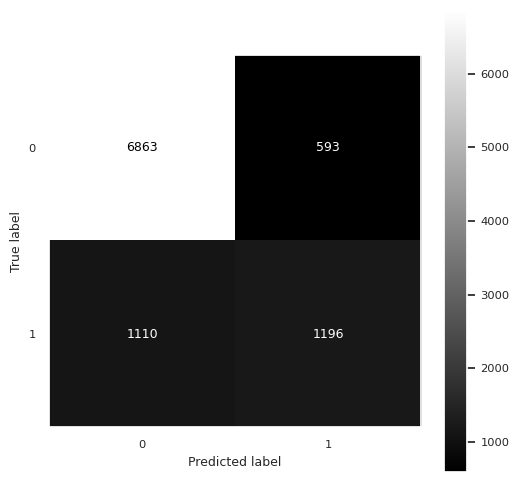

In [44]:
y_train_pred = random_forest.predict(X_train)
y_test_pred = random_forest.predict(X_test)

get_confmatrix_and_report(y_train, y_test, y_train_pred, y_test_pred)

Feature importances:
                        feature  importance
1   marital.status_Now-married    0.331059
0             education_ordenc    0.267547
2             age_group_ordenc    0.116167
3            week_hours_ordenc    0.100975
4   occupation_Exec-managerial    0.052870
5                     sex_Male    0.043058
6    occupation_Prof-specialty    0.038718
7            workclass_Private    0.026353
8  marital.status_Past-married    0.023253


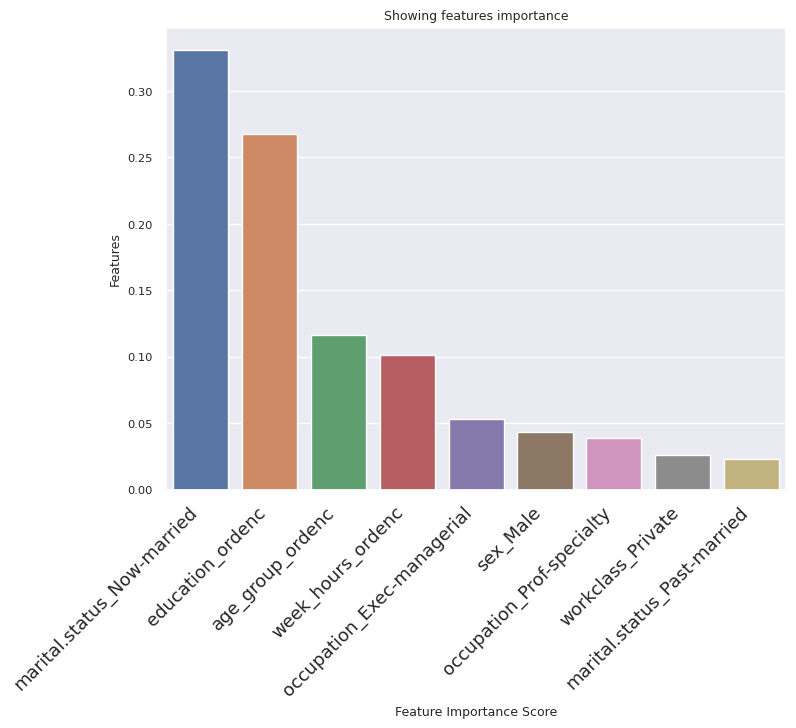

In [45]:
features_importance_df = show_features_importance(random_forest, X)

Conclusions of the Random Forest part (initial model vs model without less relevant features):

- In general terms, both of them have similar performance (initial model has better train accuracy)
- Initial model predict better class 1 (income >50k)
- Model without irrelevant features predicts better class 0 (income <=50k)

# Decision Tree

## DT model creation and evaluation

In [46]:
X = df_preproc.drop(columns=['income'])
y = df_preproc['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

decision_tree = DecisionTreeClassifier(max_depth = 12, random_state = 42)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, random_state=42)

Accuracy train: 0.8551481888035126
Accuracy test: 0.8178651915591068

Classificacion report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88      7456
           1       0.62      0.59      0.61      2306

    accuracy                           0.82      9762
   macro avg       0.75      0.74      0.74      9762
weighted avg       0.82      0.82      0.82      9762



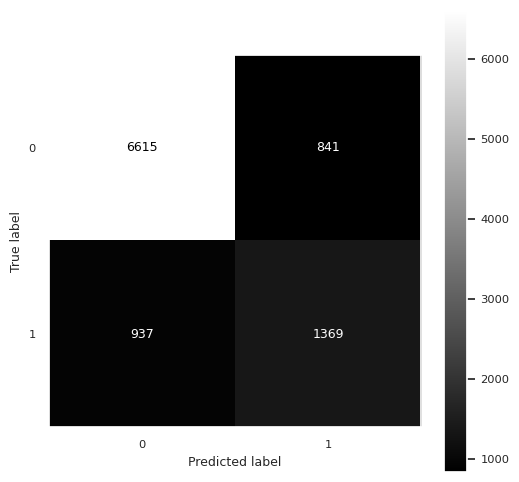

In [47]:
y_train_pred = decision_tree.predict(X_train)
y_test_pred = decision_tree.predict(X_test)

get_confmatrix_and_report(y_train, y_test, y_train_pred, y_test_pred)

Feature importances:
                               feature  importance
5          marital.status_Now-married    0.412163
2                    education_ordenc    0.255394
0                    age_group_ordenc    0.064107
1                   week_hours_ordenc    0.058302
10         occupation_Exec-managerial    0.028512
3                   workclass_Private    0.016781
4             workclass_Self-employed    0.016319
29       native.country_United-States    0.015984
27                         race_White    0.015526
25                  relationship_Wife    0.013937
16          occupation_Prof-specialty    0.012288
28                           sex_Male    0.010799
14           occupation_Other-service    0.010304
24             relationship_Unmarried    0.008993
18                   occupation_Sales    0.008135
23             relationship_Own-child    0.007067
7         marital.status_Past-married    0.006814
11         occupation_Farming-fishing    0.006668
19            occupation_Tec

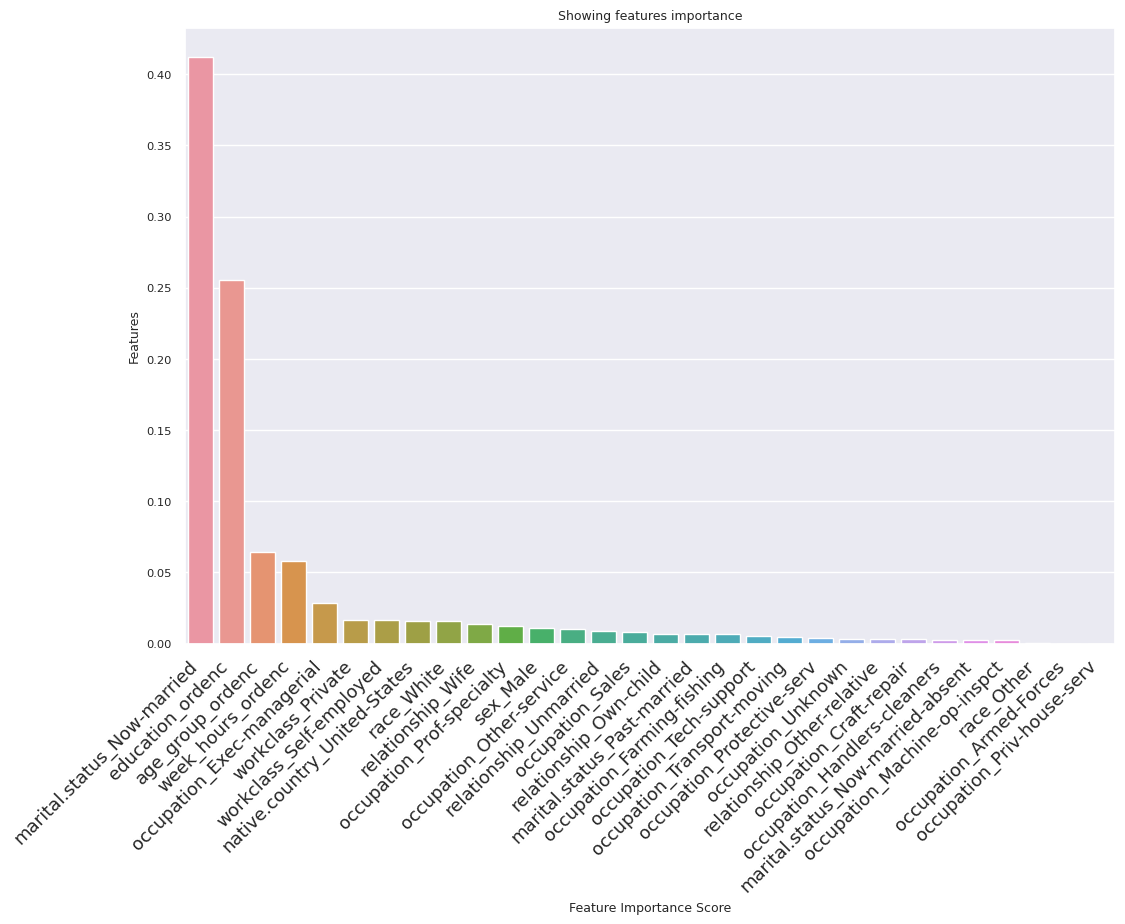

In [48]:
features_importance_df = show_features_importance(decision_tree, X, more_size=True)

## Second DT model and evaluation

In [49]:
filtered_features_df = features_importance_df[(features_importance_df["importance"] > 0.025)]
filtered_features_list = list(filtered_features_df['feature'])
filtered_features_list.append('income')
print(filtered_features_list)

df_dt_cut = df_preproc[filtered_features_list]
df_dt_cut.head()

['marital.status_Now-married', 'education_ordenc', 'age_group_ordenc', 'week_hours_ordenc', 'occupation_Exec-managerial', 'income']


,marital.status_Now-married,education_ordenc,age_group_ordenc,week_hours_ordenc,occupation_Exec-managerial,income
0,0,1,2,1,0,0
1,0,1,2,0,1,0
2,0,2,2,1,0,0
3,0,0,2,1,0,0
4,0,2,1,1,0,0


In [50]:
X = df_dt_cut.drop(columns=['income'])
y = df_dt_cut['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [51]:
decision_tree = DecisionTreeClassifier(max_depth = 12, random_state = 42)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, random_state=42)

Accuracy train: 0.8311306256860592
Accuracy test: 0.8282114320835894

Classificacion report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      7456
           1       0.69      0.50      0.58      2306

    accuracy                           0.83      9762
   macro avg       0.77      0.72      0.74      9762
weighted avg       0.82      0.83      0.82      9762



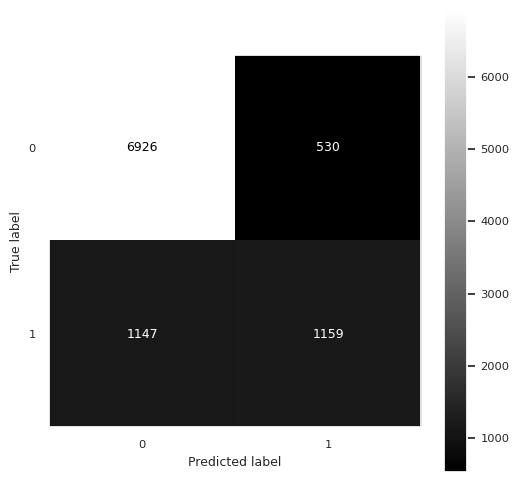

In [52]:
y_train_pred = decision_tree.predict(X_train)
y_test_pred = decision_tree.predict(X_test)

get_confmatrix_and_report(y_train, y_test, y_train_pred, y_test_pred)

Feature importances:
                       feature  importance
0  marital.status_Now-married    0.522535
1            education_ordenc    0.318297
2            age_group_ordenc    0.065762
3           week_hours_ordenc    0.058364
4  occupation_Exec-managerial    0.035042


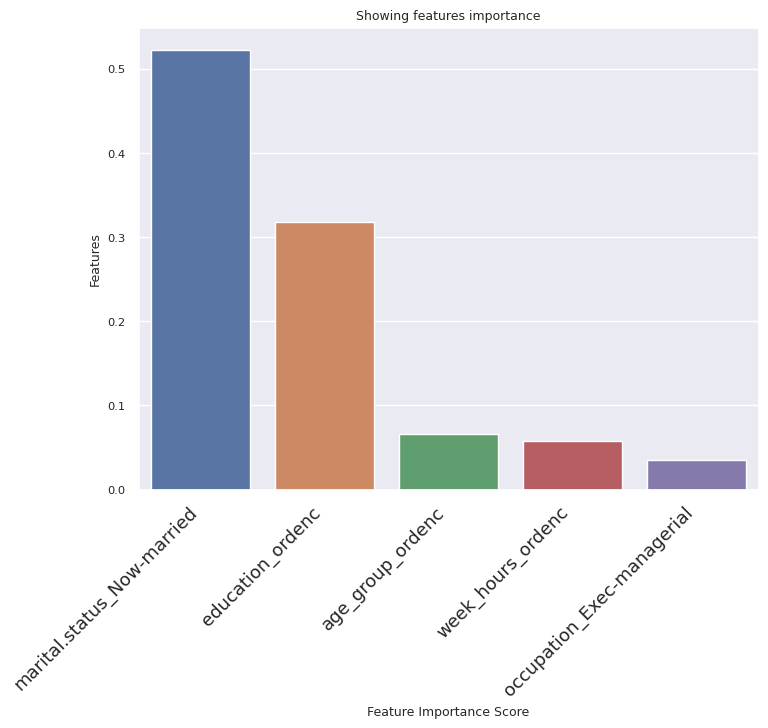

In [53]:
features_importance_df = show_features_importance(decision_tree, X)

Conclusions of the Decision Tree part (initial model vs model without less relevant features):

- In general terms, both of them have similar performance (initial model has better train accuracy)
- Initial model predict better class 1 (income >50k)
- Model without irrelevant features predicts better class 0 (income <=50k)

# Conclusion and summary

Summary of train and test accuracy:
- RF initial --> Train accuracy is 0.884 and test accuracy is 0.820
- RF second --> Train accuracy is 0.844 and test accuracy is 0.826
- DT initial --> Train accuracy is 0.855 and test accuracy is 0.818
- DT second --> Train accuracy is 0.831 and test accuracy is 0.828

Summary of performance with each class (focus on f1 score):
- RF initial --> F1 score for class 0 (income <=50k) is 0.88 and for class 1 is 0.60
- RF second --> F1 score for class 0 (income <=50k) is 0.89 and for class 1 is 0.58
- DT initial --> F1 score for class 0 (income <=50k) is 0.88 and for class 1 is 0.61
- DT second --> F1 score for class 0 (income <=50k) is 0.89 and for class 1 is 0.58

Conclusions:
- Both models perform similar with this dataset and configurations.
- There is no model that is clearly better than another, although the choice would be between the two initial models since RF has the best accuracy train and DT has the best F1score for the minority class.
- The initial imbalance of the data is reflected in the performance we obtain. The class with fewer entries (class 1) has more problems to be predicted.
- Cleaning up non-relevant features doesn't seem to have a big effect on the results, it just slightly unbalances one class in favor of the other, maintaining an overall balance.